# Eigengrasps extraction
## Load data

In [1]:
# Imports
%load_ext autoreload
%autoreload 2
from pathlib import Path
from functools import reduce

import json
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

from utils import load_dataset
from visualization import visualize_comparison, visualize_frames
from sh_kinematics import shadow_hand_fk, JOINT_LIMITS

sns.set_style("darkgrid")

root = Path() / "saves"
cp_path = Path().resolve().parents[1] / "ContactPose"
joint_names = ["wr2", "wr1", "th5", "th4", "th3", "th2", "th1", "ff4", "ff3", "ff2", "mf4", "mf3", "mf2", "rf4", "rf3", "rf2",
               "lf5", "lf4", "lf3", "lf2"]

In [2]:
# Load datasets
with open(root / "joint_verification.json", "r") as f:
    joint_verification = json.load(f)
with open(root / "sh_joints.json", "r") as f:
    sh_joints = json.load(f)
sh_joints = sorted(sh_joints, key=lambda x: x[2])
hands = load_dataset(cp_path)

In [3]:
def load_pd_df(sh_joints, joint_verification):
    COUPLING_CONST = 0.87577639751
    sh_joints = sorted(sh_joints, key=lambda x: x[2])
    # ff1, mf1, rf1, lf1 are coupled
    df = pd.DataFrame(np.array([j[0][3:] for j in sh_joints]), columns=joint_names)
    df["error"] = np.array([j[1] for j in sh_joints])
    df["valid"] = np.array([joint_verification[str(idx)] for idx in range(len(joint_verification))])
    return df

In [4]:
df = load_pd_df(sh_joints, joint_verification)

In [5]:
valid_df = df[df["valid"]]
invalid_df = df[df["valid"] == False]

## Data analysis

Valid df mean error: 0.628570772167825
Invalid df mean error: 1.5972721888505146


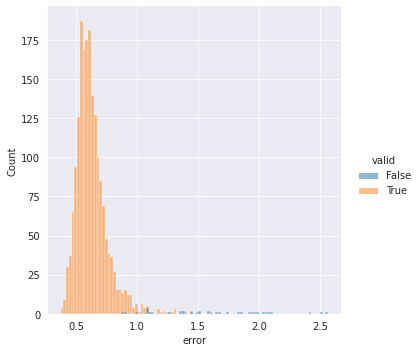

In [6]:
sns.displot(df, x="error", hue="valid")
print(f"Valid df mean error: {np.mean(valid_df['error'])}")
print(f"Invalid df mean error: {np.mean(invalid_df['error'])}")

## PCA analyis

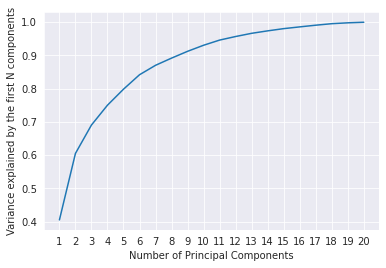

In [7]:
pca = PCA()
pca.fit(valid_df[joint_names])  # SKLearn centers the data before applying the SVD
svals = pca.singular_values_
expl_var = pca.explained_variance_ratio_
sns.lineplot(x=np.arange(1,len(expl_var)+1),y=np.cumsum(expl_var))
plt.xlabel("Number of Principal Components")
plt.xticks(np.arange(1,len(expl_var)+1))
plt.ylabel("Variance explained by the first N components")
plt.show()

### Scale and save eigengrasps
We scale the eigengrasps to $max|\lambda_i| = \frac{\theta_{max}-\theta_{min}}{2}$. Actions are later computed as $\theta_{center} + min(\theta_{max}, max(\theta_{min}, \sum_i a_i*\lambda_i))$ with $a_i \in [-1,1]$. For isolated actions we therefore reach the joint limits in the most sensitive component at the maximum action amplitude $a_i \in \{-1,1\}$. The first angle is ignored as it is not optimized during the pose fitting.

In [8]:
theta_diff = (JOINT_LIMITS["upper"] - JOINT_LIMITS["lower"]) / 2
eigengrasps = {}
for i in range(len(pca.components_)):
    scaled_joints = np.min(theta_diff[1:]/np.abs(pca.components_[i][1:]))*pca.components_[i]
    scaled_joints[0] = 0
    eigengrasps[i] = {"joints": scaled_joints.tolist(),
                       "var_ratio": pca.explained_variance_ratio_[i]}
with open(root / "eigengrasps.json", "w") as f:
    json.dump(eigengrasps, f)

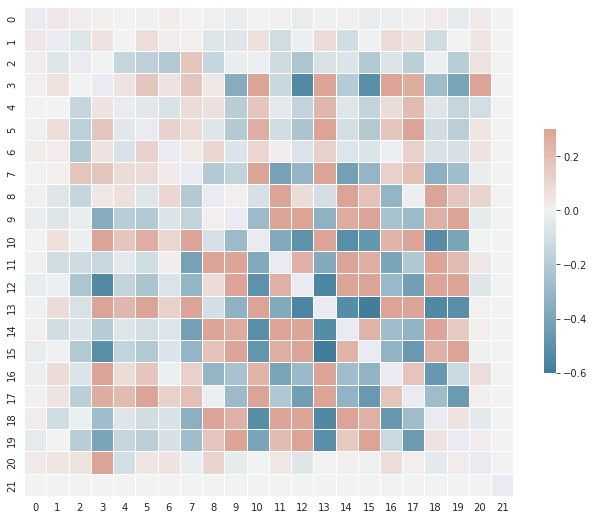

In [9]:
# Scale data to zero mean unit variance to make patterns more visible
scaler = StandardScaler()
valid_df_scaled = scaler.fit_transform(valid_df)
_pca = PCA()
_pca.fit(valid_df_scaled)

f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
corr = _pca.get_covariance()
mask = np.diag(np.ones(corr.shape[0]))
# Draw the heatmap with the mask and correct aspect ratio
# WARNING: vmax reduces actual contrast to make structures more visible, remove to get a numerically accurate heatmap
ax = sns.heatmap(corr, mask=mask, cmap=cmap, center=0, vmax=.3, 
                 square=True, linewidths=.5, cbar_kws={"shrink": 0.5})


<IPython.core.display.Javascript object>


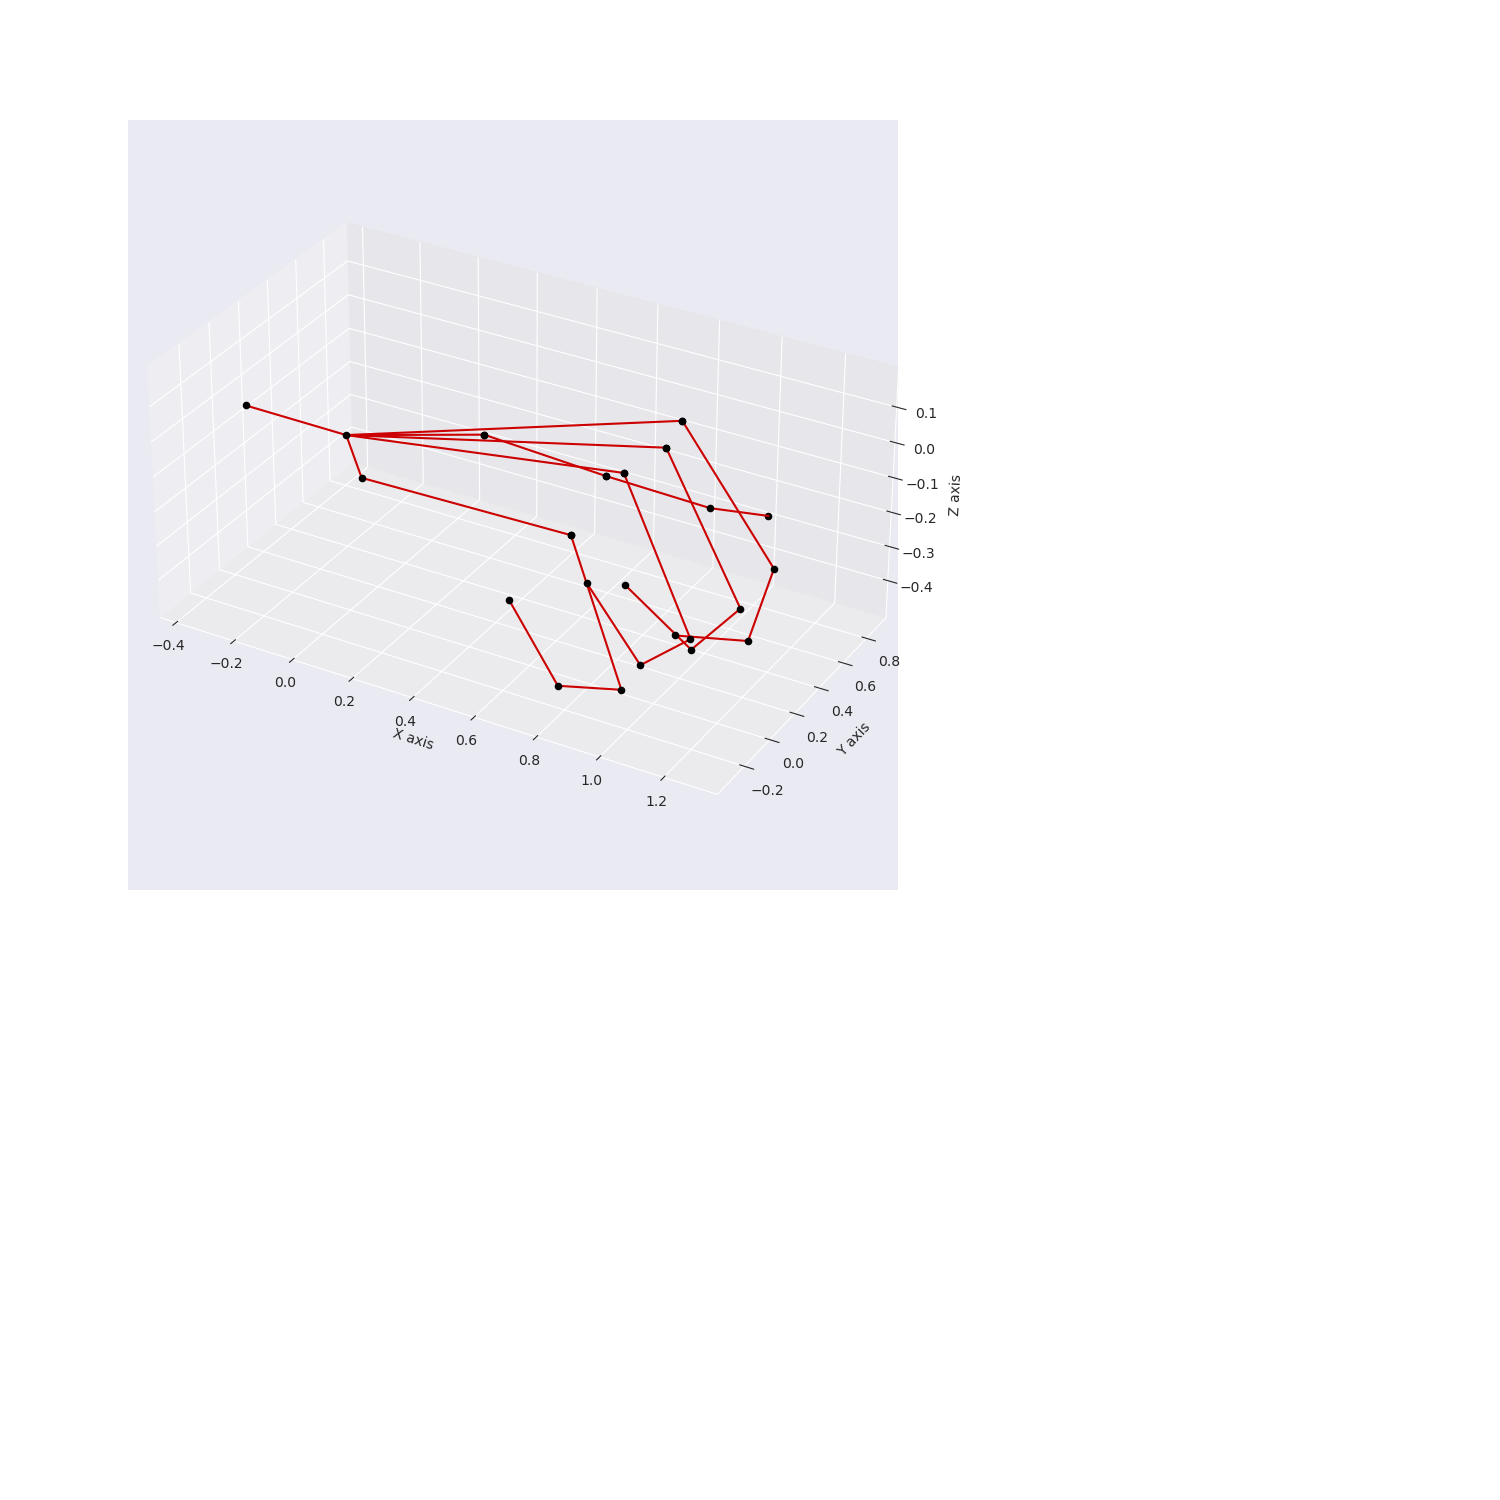

<IPython.core.display.Javascript object>


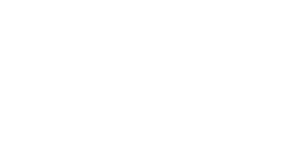

In [10]:
%matplotlib notebook

def visualize_eigengrasp(grasp):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection='3d')
    minc = np.array([np.inf, np.inf, np.inf])  # Necessary for scaling 3D plot
    maxc = np.array([-np.inf, -np.inf, -np.inf])
    for action in np.linspace(1, -1, 10):
        ax.clear()
        joints = (JOINT_LIMITS["upper"] + JOINT_LIMITS["lower"])/2 + grasp*action
        joints = np.clip(joints, JOINT_LIMITS["lower"], JOINT_LIMITS["upper"])
        frames = shadow_hand_fk(np.concatenate((np.zeros(3), joints)))
        for frame in frames:
            pos = frame[0:3,3]
            minc = np.minimum(minc, pos)
            maxc = np.maximum(maxc, pos)
            ax.scatter(*pos, color="0")
        for idx in range(1, len(frames)):
            base = idx - 1
            color = "#cc0000"
            if idx in [8, 13, 18, 23]:
                base = 1
            ax.plot([frames[base][0, 3], frames[idx][0, 3]], [frames[base][1, 3], frames[idx][1, 3]], [frames[base][2, 3], frames[idx][2, 3]], color=color)
            ax.set_xlabel("X axis")
        ax.set_ylabel("Y axis")
        ax.set_zlabel("Z axis")
        ax.set_box_aspect((maxc-minc))
        fig.canvas.draw()

eigengrasp = np.array(eigengrasps[0]["joints"])
visualize_eigengrasp(eigengrasp)
